In [ ]:
'''
Implementing a fake news classifier as detailed by Katharine Jarmul in her 
Introduction to Natural Language Processing in Python course on DataCamp. Additionally, 
contains a logistic regression model implemented from scatch as detailed by Suraj Verma
in his Logistic Regression From Scratch in Python as found on Medium and by Mirko Stojiljković
in his Stochastic Gradient Descent Algorithm With Python as found on realpython. I also implemented a
non-metaheurstic simulation method for finding a good enough solution to additive smoothing 
parameter for sklearn's MultinomialNB classifier.  
'''

In [56]:
import warnings
warnings.filterwarnings('ignore')

In [57]:
import pandas as pd
import numpy as np
from progress.bar import Bar
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import _logistic
from scipy.sparse import issparse, csr_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import sklearn.metrics as metrics
from sklearn.naive_bayes import MultinomialNB
from scipy.special import expit
from numpy.linalg import norm
import sys
import gc

In [58]:
# Data comes from Katharine Jarmul's Introduction to Natural Language Processing in Python 
# course on DataCamp
filename='/home/ichglaubeya/projects/NLP Processing/fake_or_real_news.csv'

# Read in fake or real dataset with 27MB of information to create dataframe
#done so using the chunk size method: https://www.sciencedirect.com/topics/engineering/chunk-size 
temp=[]
chunksize = 10 ** 5
for chunk in pd.read_csv(filename, chunksize=chunksize):
    temp.append(chunk)
df = pd.DataFrame(temp[0][:][:])

# printing the head of dataframe
print(df.head())
print()
# document-feature matrix shape
print(df.shape)

# do garbarge collecting
del temp
gc.collect()

   Unnamed: 0                                              title  \
0        8476                       You Can Smell Hillary’s Fear   
1       10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2        3608        Kerry to go to Paris in gesture of sympathy   
3       10142  Bernie supporters on Twitter erupt in anger ag...   
4         875   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL  

(6335, 4)


12003

In [59]:
'''Using Countvectorizer to create generic document-term matrix for machine learning. i.e.

[['gone iniches of heat, but do'],       [[1, 0, 23, 0, 15, 0, 16],
 ['love chap it I don't know' ]]  ->     [24, 20, 19, 0, 7, 6, 0]]
'''

# Create a series to store the labels: y
y = df['label']

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], y, test_size=0.33, random_state=53)

# Initialize a CountVectorizer object: count_vectorizer with english stopwords
count_vectorizer = CountVectorizer(stop_words='english')

# Learn the vocabulary and dictionary and return document-term matrix of size 4244, 56922
# i.e. 4244 documents and 56922 terms
count_train = count_vectorizer.fit_transform(X_train)

# Extract token counts out of raw text documents using the vocabulary and return
# document-term matrix of size 2091, 56922 i.e. 2091 documents and 56922 terms
count_test = count_vectorizer.transform(X_test)

# Print the first 10 features
print(count_vectorizer.get_feature_names()[:10])
print()

# Printing a random subset of word-value pairs from the dictionary
dictionary_page={key: value for key, value in count_vectorizer.vocabulary_.items() if value == np.random.randint(low=0, high=56923)}
print(dictionary_page)

# Print the first vector of the document-term matrix of the first 10 features
print(count_train.A[0][:10])

# doing garbage collecting
del df
gc.collect()

['00', '000', '0000', '00000031', '000035', '00006', '0001', '0001pt', '000ft', '000km']

{'treaties': 51634}
[0 0 0 0 0 0 0 0 0 0]


0

In [60]:
'''Using TfidfVectorizer to create Tf-IDF document-term matrix for machine learning 
The formula that is used to compute the tf-idf of term t is tf-idf(d, t) = tf(t) * idf(d, t), 
and the idf is computed as idf(d, t) = log [ n / df(d, t) ] + 1 (if ``smooth_idf=False``),
where n is the total number of documents and df(d, t) is the document frequency; the document 
frequency is the number of documents d that contain term t:  i.e.

[['gone iniches of heat, but do'],   [[0.001, 0.00, 0.0023, 0.00, 0.0015, 0.00, 0.0016, ...],
 ['love chap it I don't know  ']] -> [0.0024, 0.0020, 0.0019, 0.00, 0.007, 0.006, 0.000, ...]]
'''
# max_df: When building the vocabulary ignore terms that have a df strictly higher than 
# the given threshold (corpus-specific stop words)
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_df=0.7)

# Learn Vocabulary and idf and return tf-idf document-term matrix of size 4244, 56922
# i.e. 4244 documents and 56922 terms
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Uses the vocabulary and idf learned by fit_transform and return tf-idf document-term matrix of
# size of 2091, 56922 i.e. 2091 documents and 56922 terms
tfidf_test = tfidf_vectorizer.transform(X_test)

# Print the first 10 features
print(tfidf_vectorizer.get_feature_names()[:10])

# Print the first vector of the tf-idf document-term matrix of the first 10 features
print(tfidf_train.A[0][:10])

# doing garbage collecting
del tfidf_vectorizer
del CountVectorizer
del TfidfVectorizer
del X_test
del X_train
del chunk
del chunksize
del train_test_split
gc.collect()



['00', '000', '0000', '00000031', '000035', '00006', '0001', '0001pt', '000ft', '000km']
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


0

In [61]:
'''Transforming the document-term matrix into Compressed Sparse Row Matrix form
using scipy.sparse.csr_matrix. Reduces the memory storage by an order of magnitude as
compared to the raw format i.e. GB -> MB 
:http://www.netlib.org/utk/people/JackDongarra/etemplates/node373.html
:https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html
'''
tfidf_train= csr_matrix(tfidf_train.A, dtype=np.float64)
tfidf_test = csr_matrix(tfidf_test.A, dtype=np.float64)

0.893352462936394


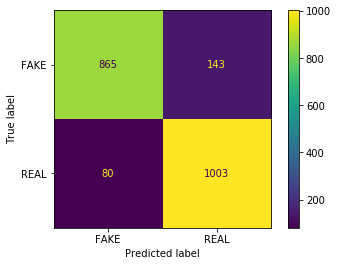


0.8565279770444764


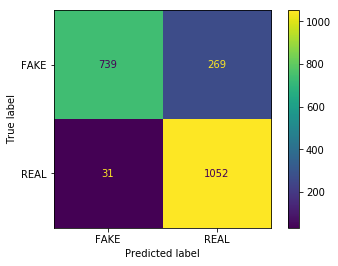

In [62]:
'''Comparining Accuracy and Confusion Matrix difference of MultinomialNB
   using term-frequency(i.e count_train) vs. term-frequency inverse document frequency
   (ie.tfidf_train) feature vectors as detailed by Katharine Jarmul's Introduction to Natural 
   Language Processing in Python course on DataCamp 
'''

# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier_one = MultinomialNB()

# Fit the classifier to the training data using tf feature vectors
nb_classifier_one.fit(count_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier_one.predict(count_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score)

# Calculate the confusion matrix: cm
ConfusionMatrixDisplay.from_predictions(y_test, pred)
plt.show()
print()

nb_classifier_two = MultinomialNB()

# Fit the classifier to the training data with tf-idf feature vectors
nb_classifier_two.fit(tfidf_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier_two.predict(tfidf_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score)

# Calculate the confusion matrix: cm
ConfusionMatrixDisplay.from_predictions(y_test, pred)
plt.show()

In [63]:
'''Non-Metaheurisic Optimization of Alpha Parameter for the MultinomialNB Model:
(i.e. not using general solving methods like Genetic Algorithms,Energy Optimizations 
like Simulated/Quantum annealing, Particle Swarm Optimizations (PSO) and/or other 
non-optimal algorithm methods)

********************************Killa Alpha*******************************************************
Intuition Behind Optimize Function:
**************************************************************************************************
General Additive/Laplace Smoothing Formula:
theta_hat = x_i + alpha/N + alpha*d (i=1,..., d), where alpha is the pseudocount  (1)
and alpha > 0

Heuristic/Optimizaion Method for Alpha for Binary Text Classification using 
tf-idf feature vectors. From a Bayesian point of view, (1) corresponds to the expected 
value of the posterior distribution of a Binomial distribution using a Beta distribution 
as the conjugate prior for alpha when the classification is binary i.e.
        E(P(p_hat|X, alpha, beta)= x_i + alpha/N + alpha + beta) for (i=1,..., d)    (2)
where p_hat is either 0 or 1; X is the tf-idf term-document matrix; N is the
number of samples.
'''
# Create the list of alphas: alphas where alpha and beta come from the Beta distribution
alpha = np.random.random_sample(size=tfidf_train.shape[0])
beta = np.random.random_sample(size=tfidf_train.shape[0])
alphas=np.random.beta(a=alpha, b=beta)


def optimize(alpha):
    # Instantiate the classifier: nb_classifier
    nb_classifier = MultinomialNB(alpha=alpha)
    # Fit to the training data
    nb_classifier.fit(tfidf_train, y_train)
    # Predict the labels: pred
    pred = nb_classifier.predict(tfidf_test)
    # Compute accuracy: score
    score = metrics.accuracy_score(y_test, pred)
    return score

# Iterate over the alphas and print the max score and alpha
temp=[]
for alpha in alphas:
    score=optimize(alpha)
    temp.append((alpha, score))
print(max(temp,key=lambda x:x[1]))


(0.001824562412315025, 0.9067431850789096)


0.9067431850789096


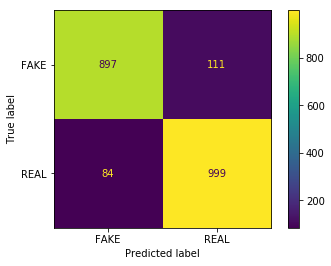

In [64]:
'''
Using the alpha value from optimize function to get a higher score for the MultinomialNB
model using tf-idf feature vectors to get 91% accuracy versus 86% accuracy 
'''
myModel=MultinomialNB(alpha=0.001824562412315025)
myModel.fit(tfidf_train, y_train)
pred_NB = myModel.predict(tfidf_test)
#Mymodel's MultinomialNB prediction with alpha parameter
print(metrics.accuracy_score(y_test, pred_NB))
ConfusionMatrixDisplay.from_predictions(y_test, pred_NB)
plt.show()

In [65]:
'''
Hybrid Implementation of Suraj Verma's Logistic Regression From Scratch in Python and
Mirko Stojiljković's Stochastic Gradient Descent Algorithm With Python and NumPy. 
Becasue I wanted to see if my coefficients could be further optimized using Stochastic 
gradient descent(i.e. because of the relationaship between MultinomialNB and linear regression), I implemented
did a warm start to the Stochastic gradient descent method:https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/warm-start/warm-start.pdf.

Also because of issues with nans due to the exploding gradient problem,
I implemented Min-Max Normalization:http://proc.conisar.org/2018/pdf/4813.pdf and l1 regularization
:https://github.com/scikit-learn/scikit-learn/blob/7e1e6d09b/sklearn/linear_model/_logistic.py#L1120
Helped a bit but not there yet :( 
'''
# min max normization
def min_max_scaling(X):
    # have to transform to float32 so it work in my virtual environment(i.e. not killed)
    X = csr_matrix(X, dtype=np.float32)
    x=X.toarray() # warning!!: will convert to raw format and os kernal may kill program due to memory constraints
    del X 
    gc.collect()
    # calculating max and min using numpy's norm function
    maxa=norm(x, np.inf, axis=0)
    mina=norm(x, -np.inf, axis=0)
    numerator = x-mina
    denominator = maxa-mina
    del x
    del mina
    del maxa
    gc.collect()
    # dividing portion
    X=np.divide(numerator, denominator)
    del numerator
    del denominator
    gc.collect()
    # transforming back to float64 for further processing
    x=csr_matrix(X, dtype=np.float64)
    del X
    gc.collect()
    return x
#Gradient calculation
def gradients(X, y, y_hat, C, weights):
    m = float(X.shape[0])
    # transposing the matrix
    X = X.transpose()
    # Gradient of loss w.r.t weights
    dw = (1/m)*(C*X.dot(y_hat-y)) + np.sum(weights) #addition of l1 penalty
    del X
    gc.collect()
    # Gradient of loss w.r.t bias.
    db = (1/m)*np.sum((y_hat - y)) 
    return dw, db
# Sigmoid function
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))
# Binary Coss-Entropy Loss or the Log Loss function 
def loss(y, y_hat):
    loss = -np.mean(y*(np.log(y_hat)) - (1.0-y)*np.log(1.0-y_hat))
    return loss
# Stochastic Gradient Descent: technically it is min-batch SGD but by setting batch size to 1 it
# is SGD
def mdmbSGDLog(gradient, x, y, start, learn_rate=0.1, batch_size=1, n_iter=50, tolerance=1e-06,
                                 dtype="float64", random_state=None, C=0.1):
    
    # Setting up the data type for numpy arrays
    dtype_ = np.dtype(dtype)
    # Calculating observation size
    n_obs = x.shape[0]
    # Calculating feature size
    n_vars = x.shape[1]
    # making sure y is numpy array of the right data type
    y = np.array(y, dtype=dtype_)
    # performing min-max normilization on the training data
    x = min_max_scaling(x)
    # setting the random number generator for reproducibility purposes
    seed = int(random_state)
    rng = np.random.default_rng(seed=seed)
    index=np.arange(tfidf_train.shape[0])
    # setting the learning rate to be a numpy array of right data type
    learn_rate = np.array(learn_rate, dtype=dtype_)
    # setting the lambda parameter for the l1 penalty to be a float data type
    C = float(C)
    # setting the tolerance to be a numpy array with right data tyep
    tolerance = np.array(tolerance, dtype=dtype_)
    # batch initialization
    batch_size = int(batch_size)
    # epoch initialization
    n_iter = int(n_iter)
######################Initialzation section#############################################################
    # bias initialization 
    b=0.0
    # warm start initialization
    if  not isinstance(start, float) and start is not None:
        vector = np.array(start, dtype=dtype_).reshape(n_vars, 1)
    else:
        vector = np.zeros((n_vars, 1), dtype=dtype_)
##########################Gradient Descent loop#####################################################################
    # Performing the gradient descent loop with a progress bar
    with Bar('Processing...') as bar:
        for i in range(n_iter):
            # random shuffling of training data
            rng.shuffle(index)
            x, y = x[index, :], y[index]
            # Performing minibatch moves
            for start in range(0, n_obs, batch_size):
                stop = start + batch_size
                x_batch, y_batch = x[start:stop, :], y[start:stop]
                y_hat = expit(x_batch.dot(vector)+ b) 
                dw, db = gradients(x_batch, y_batch, y_hat, C, vector)
                diff_w = learn_rate * dw
                diff_b = learn_rate * db
                if np.all(abs(diff_w) >= tolerance):
                    vector = vector - diff_w
                    b = b - diff_b
                else:
                    break   
            l = loss(y, expit(x.dot(vector) + b)) #calcualting the loss
            bar.next()
    return vector.reshape((-1)), b
#predict function
def predict(X, weights, bias):
    # Calculating presictions/y_hat.
    if issparse(X):
        preds = expit(X.dot(weights) + bias)
    else:
        preds = sigmoid(np.dot(X, weights)+bias)
    # if y_hat >= 0.5 --> round up to 1
    # if y_hat < 0.5 --> round up to 1
    pred_class = [1 if i > 0.5 else 0 for i in preds]
    return np.array(pred_class)


0.5222381635581061


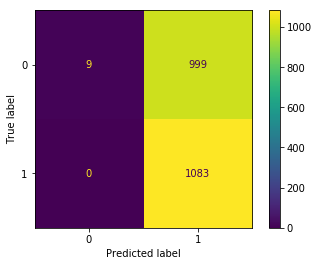

0.9139167862266858


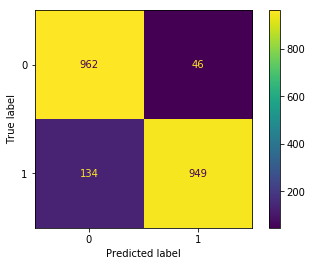

In [66]:
'''
Using Logistic Regression for Binary Text Classification for determining Fake versus Real news
'''
# Converting y variable into 1 and 0 for SGD
response_train = np.array([1 if i=='REAL' else 0 for i in y_train]).reshape((-1, 1))
response_test  = np.array([1 if i=='REAL' else 0 for i in y_test]).reshape((-1, 1))

# logistic model with myModel's previous learned coefficient as a warm start: 
# Does not perform well due to exloding gradient problem!!
weights, bias= mdmbSGDLog(gradients, x=tfidf_train, y=response_train, start=myModel.coef_[0], learn_rate=.00001, batch_size=1, n_iter=3, C=1, random_state=0)
pred = predict(tfidf_test, weights=weights, bias=myModel.intercept_)
print(metrics.accuracy_score(response_test, pred))
ConfusionMatrixDisplay.from_predictions(response_test, pred)
plt.show()

#Sklearn's logistic model with no warm start: performs very well!! 
sklogmodel=_logistic.LogisticRegression(multi_class='ovr')
sklogmodel.fit(tfidf_train, response_train)
pred2 = predict(tfidf_test, weights=sklogmodel.coef_[0], bias=sklogmodel.intercept_ )
print(metrics.accuracy_score(response_test, pred2))
ConfusionMatrixDisplay.from_predictions(response_test, pred2)
plt.show()


In [67]:
!jupyter nbconvert --to script Building\ a\ \"fake\ news\"\ classifier.ipynb

[NbConvertApp] Converting notebook Building a "fake news" classifier.ipynb to script
[NbConvertApp] Writing 15921 bytes to Building a "fake news" classifier.py
